# Intel Görüntü Sınıflandırma Projesi

Bir fotoğraftaki binaları, ormanları veya denizleri ayırt etmek için bir CNN(Evreşimsel Sinir Ağı) modeli geliştireceğiz.Bunun için Intel Image Classification veri setini kullanacağız.

# Kütüphaneleri içe aktaralım

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


2025-09-26 12:50:10.697285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758891010.905137      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758891010.961108      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Veri seti
Kaggle'dan aldığımız veri setini indirip, X_train , y_train , X_test ve y_test değişkenlerine atayalım .

Found 14034 files belonging to 6 classes.


I0000 00:00:1758891041.148868      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758891041.149608      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 3000 files belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Sınıf sayısı: 6


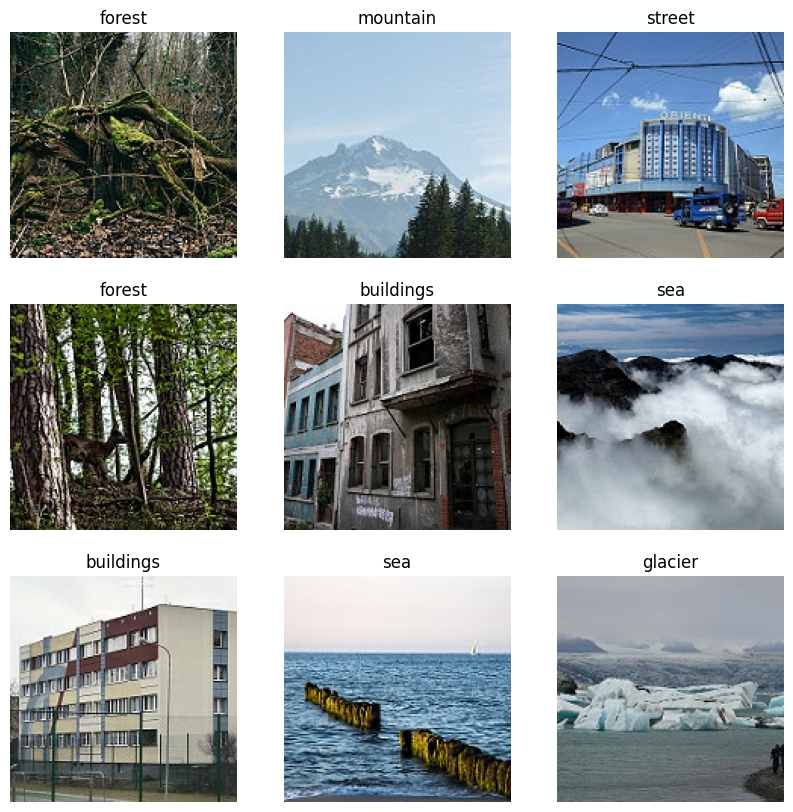

In [2]:
TRAIN_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
TEST_DIR  = "/kaggle/input/intel-image-classification/seg_test/seg_test"

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 16
SEED = 42

# Eğitim veri setini yükle
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Test veri setini yükle
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Sınıflar:", class_names)
print("Sınıf sayısı:", num_classes)

# ====================================================================================
# *** BURADAN BAŞLAYAN KISIM: GÖRSEL GÖSTERME ***
# train_ds'ten 1 batch alıp ilk 9 görseli gösteriyoruz
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        lbl = int(labels[i].numpy())
        plt.imshow(img)
        plt.title(class_names[lbl])
        plt.axis("off")
plt.show()




# Ön İşleme
Veri setimizi daha sonraki kullanımlar için ayarlayalım.Üç veri kümesine ihtiyacımız oluyor eğitim, doğrulama ve test. Eğitim veri kümesinden 10.000 görseli ayırıp doğrulama veri kümesi olarak kullanabiliriz.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Parametreler
TRAIN_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 64
SEED = 42

# Data generator (augmentation sadece train için olacak)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Önce tüm train datasını alıyoruz
all_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Numpy array'e dönüştür
X, y = [], []
for i in range(len(all_data)):
    X.append(all_data[i][0])
    y.append(all_data[i][1])
    if (i+1)*BATCH_SIZE >= all_data.samples:  # tüm dataset bitince dur
        break

X = np.concatenate(X)
y = np.concatenate(y)

print("Toplam veri:", X.shape[0])

# 80-10-10 split
# Önce %80 train, %20 geçici ayır
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# %20 içinden %50-%50 ile validation ve test (%10-%10 toplam veri)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# Tekrar generator'a sok
train_generator = train_datagen.flow(
    X_train, y_train, batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
validation_generator = test_datagen.flow(
    X_val, y_val, batch_size=BATCH_SIZE, shuffle=False
)
test_generator = test_datagen.flow(
    X_test, y_test, batch_size=BATCH_SIZE, shuffle=False
)

print("Train seti:", train_generator.n)
print("Validation seti:", validation_generator.n)
print("Test seti:", test_generator.n)



Found 14034 images belonging to 6 classes.
Toplam veri: 14034
Train seti: 11227
Validation seti: 1403
Test seti: 1404


# Sinir Ağının Oluşturalım
Modelimizin nesnesini oluşturmak için tf.keras.Sequential() kullanacağız ve Katmanları oluşturacağız.Conv2D(Konvolüsyon Katman),MaxPooling2D(Havuzlama Katmanı),Flatten,Dense(Tam Bağlantılı Katman),Dropout)

In [4]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# =========================
# Model Mimarisi
# =========================

model = models.Sequential()

# Giriş katmanı
model.add(layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))

# 1. Konvolüsyon Bloğu
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# 2. Konvolüsyon Bloğu
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# 3. Konvolüsyon Bloğu
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# 4. Konvolüsyon Bloğu
model.add(layers.Conv2D(256, (3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Düzleştir + Tamamen bağlı katmanlar
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))

# Çıkış katmanı
model.add(layers.Dense(num_classes, activation="softmax"))

# Modeli derle
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Model özeti
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,816,454 (26.00 MB)

 Trainable params: 6,815,494 (26.00 MB)

 Non-trainable params: 960 (3.75 KB)

# Model Eğitme

In [5]:
EPOCHS = 40

history = model.fit(
    train_generator,
    steps_per_epoch=int(np.ceil(train_generator.n / BATCH_SIZE)),
    validation_data=validation_generator,
    validation_steps=int(np.ceil(validation_generator.n / BATCH_SIZE)),
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1758891227.990941      67 service.cc:148] XLA service 0x7eebe4047b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758891227.991820      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758891227.991843      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758891228.513943      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/176 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.1367 - loss: 4.3339 

I0000 00:00:1758891235.404663      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 331ms/step - accuracy: 0.4373 - loss: 1.9688 - val_accuracy: 0.1618 - val_loss: 5.4583
Epoch 2/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 290ms/step - accuracy: 0.5856 - loss: 1.1036 - val_accuracy: 0.1618 - val_loss: 11.3105
Epoch 3/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 52s 293ms/step - accuracy: 0.6135 - loss: 1.0295 - val_accuracy: 0.1732 - val_loss: 7.9160
Epoch 4/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 292ms/step - accuracy: 0.6449 - loss: 0.9441 - val_accuracy: 0.4868 - val_loss: 2.4985
Epoch 5/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 52s 293ms/step - accuracy: 0.6642 - loss: 0.8965 - val_accuracy: 0.6814 - val_loss: 0.8441
Epoch 6/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 52s 298ms/step - accuracy: 0.6690 - loss: 0.8769 - val_accuracy: 0.5203 - val_loss: 1.7122
Epoch 7/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 291ms/step - accuracy: 0.6988 - loss: 0.8092 - val_accuracy: 0.7234 - val_loss: 0.7555
Epoch 8/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 290ms/step - accuracy: 0.7051 - loss: 0.7989 - va

# Sonuçları Görselleştirelim ve Doğruluk Grafiğini Oluşturalım

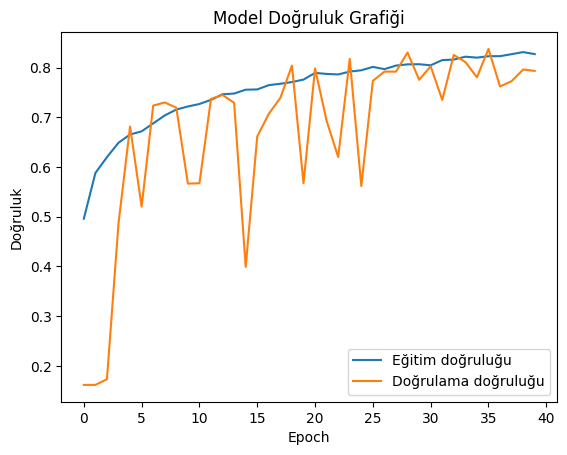

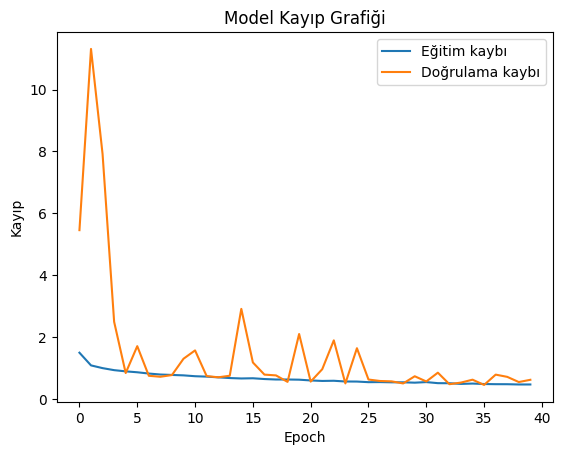

In [6]:
# Eğitim ve doğrulama doğruluğunu görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama doğruluğu')

plt.title('Model Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını görselleştirme
plt.plot(history.history['loss'], label='Eğitim kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama kaybı')

plt.title('Model Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()


# Performans değerlendirmesi

In [7]:
# Test veri setindeki performansı değerlendir
test_loss, test_accuracy = model.evaluate(test_generator)

print("\n--- Model Performansı ---")
print(f"Test Kayıp Değeri (Loss): {test_loss:.4f}")
print(f"Test Doğruluk Oranı (Accuracy): {test_accuracy:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7917 - loss: 0.5772

--- Model Performansı ---
Test Kayıp Değeri (Loss): 0.6072
Test Doğruluk Oranı (Accuracy): 0.7934


# Bir Tahmin Deneyelim 
Başlangıçta seçtiğimiz örneği alıp onun üzerinden bir tahminde bulunuyoruz.
Tahmin edilen sınıfı ve tahmin olasılığını bulup sonuçları yazdırıyoruz.

Sınıflar: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Seçilen resim: /kaggle/input/intel-image-classification/seg_test/seg_test/forest/23502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


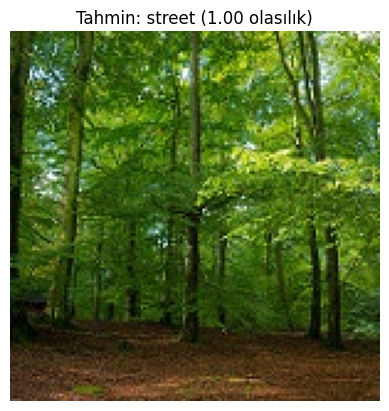

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# --- 1) Test klasöründen rastgele resim seç ---
base_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"
class_names = os.listdir(base_dir)  # ['buildings', 'forest', 'glacier', ...]
print("Sınıflar:", class_names)

# Rastgele bir sınıf seçelim
random_class = np.random.choice(class_names)
class_dir = os.path.join(base_dir, random_class)

# O sınıftan rastgele bir resim seçelim
random_file = np.random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, random_file)
print("Seçilen resim:", img_path)

# --- 2) Görseli yükle ve modele uygun hale getir ---
img = image.load_img(img_path, target_size=(150, 150))  # modelin giriş boyutu
img_array = image.img_to_array(img) / 255.0             # normalize (0–1 arası)
img_batch = np.expand_dims(img_array, axis=0)           # batch formatı (1,150,150,3)

# --- 3) Tahmin yap ---
prediction = model.predict(img_batch)
predicted_class = class_names[np.argmax(prediction)]

# --- 4) Sonucu görselleştir ---
plt.imshow(img_array)
plt.axis("off")
plt.title(f"Tahmin: {predicted_class} ({np.max(prediction):.2f} olasılık)")
plt.show()

